In [1]:
%matplotlib inline

In [2]:
from IPython.display import display

import pandas as pd
import pint  # Unit conversion from inches to mm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from svg_model.svgload import svg_parser
from svg_model.data_frame import (get_svg_frame, close_paths, get_nearest_neighbours,
                                  get_path_areas, get_bounding_boxes, get_path_infos,
                                  get_bounding_box)



def scale_paths(df, axis, factor):
    df_scaled = df.copy()
    df_scaled[axis] = (df_scaled[axis + '_center'] +
                       df_scaled[axis + '_center_offset'] * factor)
    return df_scaled


def extend_paths(df, axis, distance):
    df_scaled = df.copy()
    offsets = df_scaled[axis + '_center_offset'].copy()
    offsets[offsets < 0] -= distance
    offsets[offsets >= 0] += distance
    df_scaled[axis] = df_scaled[axis + '_center'] + offsets
    return df_scaled


# Convert Inkscape pixels-per-inch (PPI) to pixels-per-mm (PPmm).
ureg = pint.UnitRegistry()

INKSCAPE_PPI = 90
INKSCAPE_PPmm = INKSCAPE_PPI / ureg.inch.to('mm')

-----------------------------------------------

## Work in progress - scale each path in an attempt to find "adjacent" paths

In [58]:
from IPython.display import display


svg_filepath = 'test_device_1.svg'

# Read device layout from SVG file.
df_device = get_svg_frame(svg_filepath)

# Offset device, such that all coordinates are >= 0.
df_device[['x', 'y']] -= df_device[['x', 'y']].min()

# Scale path coordinates based on Inkscape default of 90 pixels-per-inch.
df_device[['x', 'y']] /= INKSCAPE_PPmm.magnitude

# Get coordinates of center of each path.
df_paths = get_path_infos(df_device)
path_centers = df_paths[['x', 'y']] + .5 * df_paths[['width', 'height']].values
df_device['x_center'] = path_centers.x[df_device.path_id].values
df_device['y_center'] = path_centers.y[df_device.path_id].values

# Calculate coordinate of each path vertex relative to center point of path.
center_offset = df_device[['x', 'y']] - df_device[['x_center', 'y_center']].values
df_device = df_device.join(center_offset, rsuffix='_center_offset')

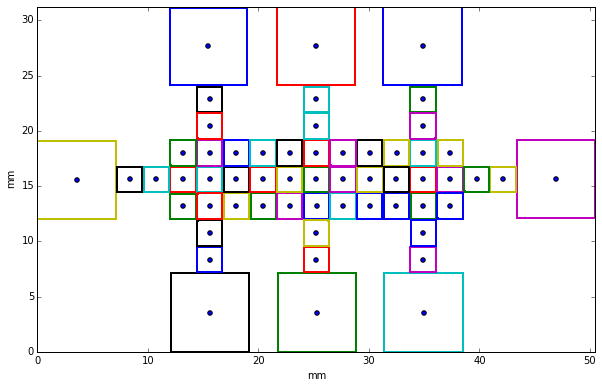

In [59]:
# Create blank axis to draw on.
fig, axis = plt.subplots(figsize=(10, 10))
axis.set_aspect(True)

# Get reference to cycling color generator.
colors = axis._get_lines.color_cycle

# Assign a color to each path identifier.
path_ids = df_device.path_id.unique()
path_colors = pd.Series([colors.next() for i in xrange(path_ids.shape[0])],
                        index=path_ids)

# Draw electrode paths.
for path_id, path_i in close_paths(df_device).groupby('path_id'):
    color = path_colors[path_id]
    poly = Polygon(path_i[['x', 'y']].values, edgecolor=color, closed=True,
                   linewidth=2, facecolor='none')
    axis.add_patch(poly)
 
# Set limits of axis view to device boundaries.
axis.set_xlim(df_device.x.min(), df_device.x.max())
axis.set_ylim(df_device.y.min(), df_device.y.max())

# Draw center of each electrode paths.
path_centers = df_device[['x_center', 'y_center']].drop_duplicates()
axis.scatter(path_centers.x_center, path_centers.y_center)
    
# Draw electrode paths, stretched in the x-dimension away from path centers.
# df_scaled = scale_paths(df_device, 'x', 1.25)  # Scale x rel to path size
# df_scaled = scale_paths(df_device, 'y', 1.25)  # Scale y rel to path size

# for path_id, path_i in close_paths(df_scaled).groupby('path_id'):
#     color = path_colors[path_id]
#     poly = Polygon(path_i[['x', 'y']].values, edgecolor=color, closed=True,
#                    linewidth=2, facecolor='none', linestyle='dashed')
#     axis.add_patch(poly)

axis.set_xlabel('mm')
axis.set_ylabel('mm')

## Find corners of each solid path outline

In [60]:
df_scaled_x = extend_paths(df_device, 'x', .5)  # Extend x coords by abs units
df_scaled_y = extend_paths(df_device, 'y', .5)  # Extend y coords by abs units

df_corners = df_device.groupby('path_id').agg({'x': ['min', 'max'], 'y': ['min', 'max'], })


## Find adjacent square for every square

In [63]:
#Connected electrodes are recorded 
df_connected
row_list = [] 

for pathNumber in df_device['path_id'].drop_duplicates():
    df_stretched = df_scaled_x[df_scaled_x.path_id.isin([pathNumber])]
    xmin_x, xmax_x, ymin_x, ymax_x = df_stretched.x.min(), df_stretched.x.max(), df_stretched.y.min(), df_stretched.y.max()
    df_stretched = df_scaled_y[df_scaled_y.path_id.isin([pathNumber])]
    xmin_y, xmax_y, ymin_y, ymax_y = df_stretched.x.min(), df_stretched.x.max(), df_stretched.y.min(), df_stretched.y.max()

    #Some conditions unnecessary if it is assumed that electrodes don't overlap
    adjacent = df_corners[
                ((df_corners.x['min'] < xmax_x) & (df_corners.x['max'] >= xmax_x)
                |(df_corners.x['min'] < xmin_x) & (df_corners.x['max'] >= xmin_x)) # checks in x stretched direction
               & (df_corners.y['min'] < ymax_x) & (df_corners.y['max'] > ymin_x)# check if y is within bounds
        
        #mabye do ymax_x - df_corners.y['min'] > threshold & df_corners.y['max'] - ymin_x > threshold

                |((df_corners.y['min'] < ymax_y) & (df_corners.y['max'] >= ymax_y)
                 |(df_corners.y['min'] < ymin_y) & (df_corners.y['max'] >= ymin_y)) # checks in y stretched direction
               & ((df_corners.x['min'] < xmax_y) & (df_corners.x['max'] > xmin_y)) # check if x in within bounds

              ].index.values
    
    for path in adjacent:
        temp_dict = {}
        reverse_dict = {}
        
        temp_dict ['source'] = pathNumber
        reverse_dict['source'] = path
        temp_dict ['destination'] = path
        reverse_dict['destination'] = pathNumber
        
        if(reverse_dict not in row_list):
            row_list.append(temp_dict)
        
df_connected = pd.DataFrame(row_list)

#Drawing the Connections

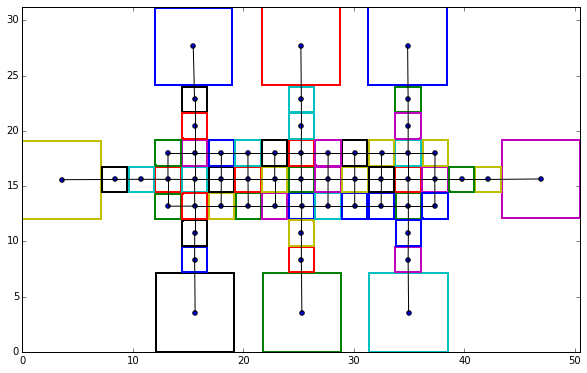

In [64]:

# Create blank axis to draw on.
fig, axis = plt.subplots(figsize=(10, 10))
axis.set_aspect(True)

# Get reference to cycling color generator.
colors = axis._get_lines.color_cycle

# Assign a color to each path identifier.
path_ids = df_device.path_id.unique()
path_colors = pd.Series([colors.next() for i in xrange(path_ids.shape[0])],
                        index=path_ids)

# Draw electrode paths
for path_id, path_i in close_paths(df_device).groupby('path_id'):
    color = path_colors[path_id]
    poly = Polygon(path_i[['x', 'y']].values, edgecolor=color, closed=True,
                   linewidth=2, facecolor='none')
    axis.add_patch(poly)
    
    
    
axis.set_xlim(df_device.x.min(), df_device.x.max())
axis.set_ylim(df_device.y.min(), df_device.y.max())

path_centers = df_device[['path_id', 'x_center', 'y_center']].drop_duplicates()
axis.scatter(path_centers.x_center, path_centers.y_center)

#Draws the connections
for index, row in df_connected.iterrows():
    path_current = path_centers[path_centers.path_id == row['source']]
    path_adjacent = path_centers[path_centers.path_id == row['destination']]

    path_current = path_current.append(path_adjacent)

    poly = Polygon(path_current[['x_center','y_center']].values)
    axis.add_patch(poly)
        
